Epistasis Analysis: Filtering the WDS-Model Meta-data for Known Epistatic Mutants

In [1]:
from deepBreaks.preprocessing import read_data
import pandas as pd
import re

def has_all_single_counterparts(row, single_mutations_df, wiggle_room = 1):
    """Checks if all individual mutations in a multi-mutant have single mutant entries and whether those mutants demonstrate epistasis."""
    wt_accession = row["WT_Acc"].split('.')[0]
    abs_diff = int(row["Reg_Diff"])
    epi_check = 0
    
    acc = row['WT_Acc']
    acc = acc.split('.')[0]
    wt_accession = re.compile(f"^{acc}")
            
    if ',' in row["Mutations"]:
        mutations = row["Mutations"].split(',') 
    elif '/' in row["Mutations"]:
        mutations = row["Mutations"].split('/') 
    else:
        mutations = row["Mutations"].split('_') 
        
 
    for mutation in mutations:
        has_countr_prt = False
        for indx in single_mutations_df.index:
            if ((wt_accession.match(single_mutations_df["WT_Acc"][indx])) and (single_mutations_df["Mutations"][indx].strip() == mutation.strip())):
                has_countr_prt = True
                epi_check += int(single_mutations_df["Reg_Diff"][indx])
                
                break
            else:
                pass
        if has_countr_prt == False:
            return False

    #Checking to see if the mutation is just additive or epistatic.
    if abs(abs_diff - epi_check) <= wiggle_room:
        is_epistatic_mut = False
    else:
        is_epistatic_mut = True
    return True, is_epistatic_mut, epi_check

wrk_dir = './VPOD_1.1'
MutCompFile = f"{wrk_dir}/wt_mut_comp.csv"
#meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
comp_file = read_data(MutCompFile, seq_type = None, is_main=False)

In [2]:
# Extract single mutations 
single_mutations_df = comp_file[comp_file["mutant_type"] == "Single Mutation"].copy()
multi_mutations_df = comp_file[comp_file["mutant_type"] == "Multiple Mutations"].copy()


In [3]:
single_mutations_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum
S131,AB043817.1_S292A,AB043817.1,S292A,498.0,486.0,-12.0,12.0,#762a83,Single Mutation,Chordata
S69,AB084929_S292A,AB084929.1,S292A,498.0,487.0,-11.0,11.0,#762a83,Single Mutation,Chordata
S71,AB084938_A292S,AB084938.1,A292S,491.0,505.0,14.0,14.0,#762a83,Single Mutation,Chordata
S70,AB084945_S292A,AB084945.1,S292A,500.0,488.0,-12.0,12.0,#762a83,Single Mutation,Chordata
S187,AB087805.2_I49C,AB087805.2,I49C,463.0,467.0,4.0,4.0,#c9c9c9,Single Mutation,Chordata


In [4]:
multi_mutations_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum
S195,AB087805.2_L46F_I49C_S94T_V111A_M112I,AB087805.2,"L46F, I49C, S94T, V111A, M112I",472.0,467.0,-5.0,5.0,#c9c9c9,Multiple Mutations,Chordata
S194,AB087805.2_S94T_V111A_M112I,AB087805.2,"S94T, V111A, M112I",471.0,467.0,-4.0,4.0,#c9c9c9,Multiple Mutations,Chordata
S193,AB087805.2_V111A_M112I,AB087805.2,"V111A, M112I",470.0,467.0,-3.0,3.0,#c9c9c9,Multiple Mutations,Chordata
S413,AB208675.1_S117A_F177Y,AB208675.1,"S117A,F177Y",425.0,450.0,25.0,25.0,#762a83,Multiple Mutations,Streptophyta
S171,AB223053.1_Q122E_S292A,AB223053.1,"Q122E, S292A",469.0,452.0,-17.0,17.0,#762a83,Multiple Mutations,Chordata


In [5]:
has_singles_list = []
is_epistatic_list = []
additive_effects = []

for row in multi_mutations_df.index:
    try:
        has_singles,is_epistatic,addEfct= has_all_single_counterparts(multi_mutations_df.loc[row], single_mutations_df)
        has_singles_list.append(has_singles)
        is_epistatic_list.append(is_epistatic)
        additive_effects.append(addEfct)
    except:    
        has_singles_list.append((has_all_single_counterparts(multi_mutations_df.loc[row], single_mutations_df)))
multi_mutations_df["has_all_singles"] = has_singles_list

In [6]:
# Filter to keep only the desired multi-mutants
filtered_multi_mutations_df = multi_mutations_df[multi_mutations_df["has_all_singles"]].copy()
filtered_multi_mutations_df = filtered_multi_mutations_df.drop(columns="has_all_singles")
filtered_multi_mutations_df["is_epistatic_mut"] = is_epistatic_list
filtered_multi_mutations_df["additive_exp_shift"] = additive_effects
filtered_multi_mutations_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum,is_epistatic_mut,additive_exp_shift
S195,AB087805.2_L46F_I49C_S94T_V111A_M112I,AB087805.2,"L46F, I49C, S94T, V111A, M112I",472.0,467.0,-5.0,5.0,#c9c9c9,Multiple Mutations,Chordata,True,7
S194,AB087805.2_S94T_V111A_M112I,AB087805.2,"S94T, V111A, M112I",471.0,467.0,-4.0,4.0,#c9c9c9,Multiple Mutations,Chordata,True,0
S193,AB087805.2_V111A_M112I,AB087805.2,"V111A, M112I",470.0,467.0,-3.0,3.0,#c9c9c9,Multiple Mutations,Chordata,True,0
S413,AB208675.1_S117A_F177Y,AB208675.1,"S117A,F177Y",425.0,450.0,25.0,25.0,#762a83,Multiple Mutations,Streptophyta,True,17
S823,AF133907_I46F_V49I_G164A,AF133907,"I46F,V49I,G164A",438.0,437.0,-1.0,1.0,#c9c9c9,Multiple Mutations,Chordata,True,-5


In [7]:
epistatic_muts_df = filtered_multi_mutations_df[filtered_multi_mutations_df["is_epistatic_mut"]].copy()
epistatic_muts_df = epistatic_muts_df.drop(columns="is_epistatic_mut")
epistatic_muts_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum,additive_exp_shift
S195,AB087805.2_L46F_I49C_S94T_V111A_M112I,AB087805.2,"L46F, I49C, S94T, V111A, M112I",472.0,467.0,-5.0,5.0,#c9c9c9,Multiple Mutations,Chordata,7
S194,AB087805.2_S94T_V111A_M112I,AB087805.2,"S94T, V111A, M112I",471.0,467.0,-4.0,4.0,#c9c9c9,Multiple Mutations,Chordata,0
S193,AB087805.2_V111A_M112I,AB087805.2,"V111A, M112I",470.0,467.0,-3.0,3.0,#c9c9c9,Multiple Mutations,Chordata,0
S413,AB208675.1_S117A_F177Y,AB208675.1,"S117A,F177Y",425.0,450.0,25.0,25.0,#762a83,Multiple Mutations,Streptophyta,17
S823,AF133907_I46F_V49I_G164A,AF133907,"I46F,V49I,G164A",438.0,437.0,-1.0,1.0,#c9c9c9,Multiple Mutations,Chordata,-5


In [8]:
epistatic_muts_df.to_csv(path_or_buf= f'{wrk_dir}/epistatic_muts.csv',index_label=True,mode="w")

Epistasis Analysis: Checking the Performance of Different Models on Predicting Epistasis

In [1]:
from deepBreaks.preprocessing import read_data
import pandas as pd

wrk_dir = './VPOD_1.1'

EpitestFileName = f"{wrk_dir}/epistasis_full_test_results_lgbm.csv"
WdstestFileName = f"{wrk_dir}/wds_itr_test_results.csv"
WTtestFileName = f"{wrk_dir}/wt_all_muts_pred_results.csv"

epi_test = read_data(EpitestFileName, seq_type = None, is_main=False)
wds_test = read_data(WdstestFileName, seq_type = None, is_main=False)
wt_test = read_data(WTtestFileName, seq_type = None, is_main=False)

In [2]:
epi_acc_list = epi_test.Accession.to_list()

epi_test = epi_test.set_index(epi_test['Accession'])
epi_test = epi_test.drop(columns='Accession')

wds_test = wds_test.set_index(wds_test['Accession'])
wds_test = wds_test.drop(columns='Accession')
wds_test = wds_test.loc[epi_acc_list]

wt_test = wt_test.set_index(wt_test['Accession'])
wt_test = wt_test.drop(columns='Accession')
wt_test = wt_test.loc[epi_acc_list]

In [3]:
epi_test['Sqr_Err'] = epi_test['Difference']**2
wds_test['Sqr_Err'] = wds_test['Difference']**2
wt_test['Sqr_Err'] = wt_test['Difference']**2

epi_test = epi_test.sort_values('Accession')
wds_test = wds_test.sort_values('Accession')
wt_test = wt_test.sort_values('Accession')

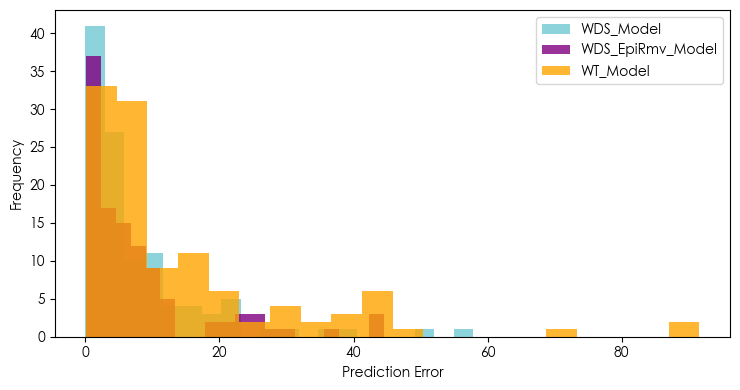

In [37]:

import matplotlib.pyplot as plt
import scipy.stats as st
# ... (your existing code to calculate errors_model1 and errors_model2)

# Histogram
plt.hist(abs(wds_test['Difference']), bins=20, alpha=0.6, label='WDS_Model', color='#41b6c4')
plt.hist(abs(epi_test['Difference']), bins=20, alpha=0.8, label='WDS_EpiRmv_Model', color='purple')
plt.hist(abs(wt_test['Difference']), bins=20, alpha=0.8, label='WT_Model', color='orange')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
#plt.title('Histogram of Prediction Errors')
plt.show()

In [38]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]")

statistic, p_value = st.wilcoxon(wds_test['Sqr_Err'], wt_test['Sqr_Err'], alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]
Wilcoxon Test: Statistic = 1371.0 p-value = 1.604624812709871e-07 

Median of WDS-Model Square-Error = 22.1nm
Mean of WDS-Model Square-Error (MSE) = 157.3 // Root Mean Square Error (RMSE) = 12.5nm

Median of WT-Model Square-Error = 65.3nm
Mean of WT-Model Square-Error (MSE) = 495.2 // Root Mean Square Error (RMSE) = 22.3nm


In [39]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], wds_test['Sqr_Err'], alternative='two-sided')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of EpiRmv-WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of EpiRmv-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]
Wilcoxon Test: Statistic = 2894.0 p-value = 0.5289262076569157 

Median of WDS-Model Square-Error = 22.1nm
Mean of WDS-Model Square-Error (MSE) = 157.3 // Root Mean Square Error (RMSE) = 12.5nm

Median of EpiRmv-WDS-Model Square-Error = 25.3nm
Mean of EpiRmv-Model Square-Error (MSE) = 153.0 // Root Mean Square Error (RMSE) = 12.4nm


In [6]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], wt_test['Sqr_Err'], alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of EpiRmv-WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of EpiRmv-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]
Wilcoxon Test: Statistic = 1497.0 p-value = 1.0685164274059859e-06 

Median of WT-Model Square-Error = 65.3nm
Mean of WT-Model Square-Error (MSE) = 495.2 // Root Mean Square Error (RMSE) = 22.3nm

Median of EpiRmv-WDS-Model Square-Error = 25.3nm
Mean of EpiRmv-Model Square-Error (MSE) = 153.0 // Root Mean Square Error (RMSE) = 12.4nm


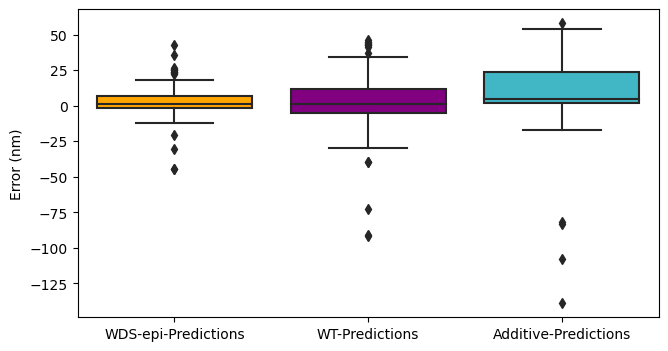

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']

sns.boxplot(data=[epi_test['Difference'], wt_test['Difference'], epi_test['Adtv_Err']], dodge=False, palette=palette, saturation=1)
# Customize axis labels
plt.xticks([0, 1, 2], ["WDS-epi-Predictions", "WT-Predictions", "Additive-Predictions"])
#plt.xlabel('Predictor')
plt.ylabel('Error (nm)')

#save file
fileout = 'epi_iter_test_err3_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_err3_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

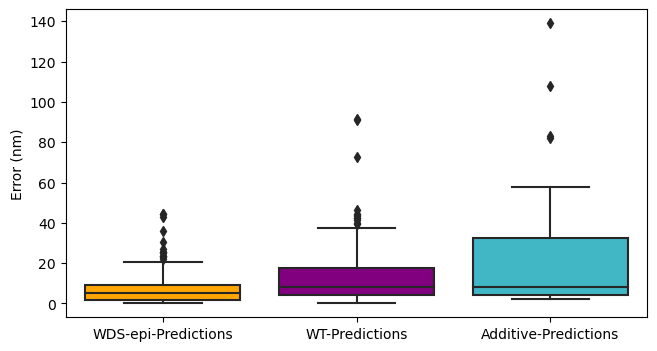

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']

sns.boxplot(data=[abs(epi_test['Difference']), abs(wt_test['Difference']), abs(epi_test['Adtv_Err'])], dodge=False, palette=palette, saturation=1)
# Customize axis labels
plt.xticks([0, 1, 2], ["WDS-epi-Predictions", "WT-Predictions", "Additive-Predictions"])
#plt.xlabel('Predictor')
plt.ylabel('Error (nm)')

#save file
fileout = 'epi_iter_test_err_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_err_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

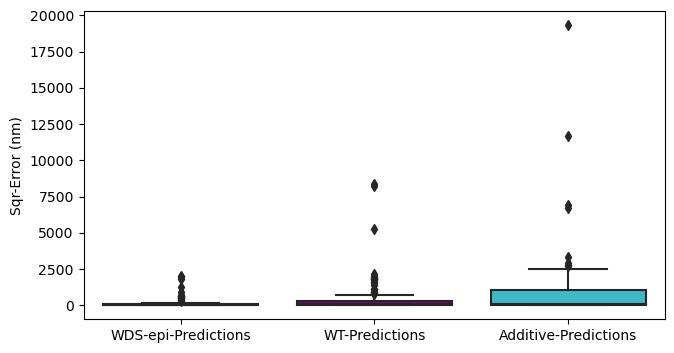

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']

sns.boxplot(data=[epi_test['Sqr_Err'], wt_test['Sqr_Err'], epi_test['Adtv_Err']**2], dodge=False, palette=palette, saturation=1)
# Customize axis labels
plt.xticks([0, 1, 2], ["WDS-epi-Predictions", "WT-Predictions", "Additive-Predictions"])
#plt.xlabel('Predictor')
plt.ylabel('Sqr-Error (nm)')

#save file
fileout = 'epi_iter_test_sqr_err_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_sqr_err_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

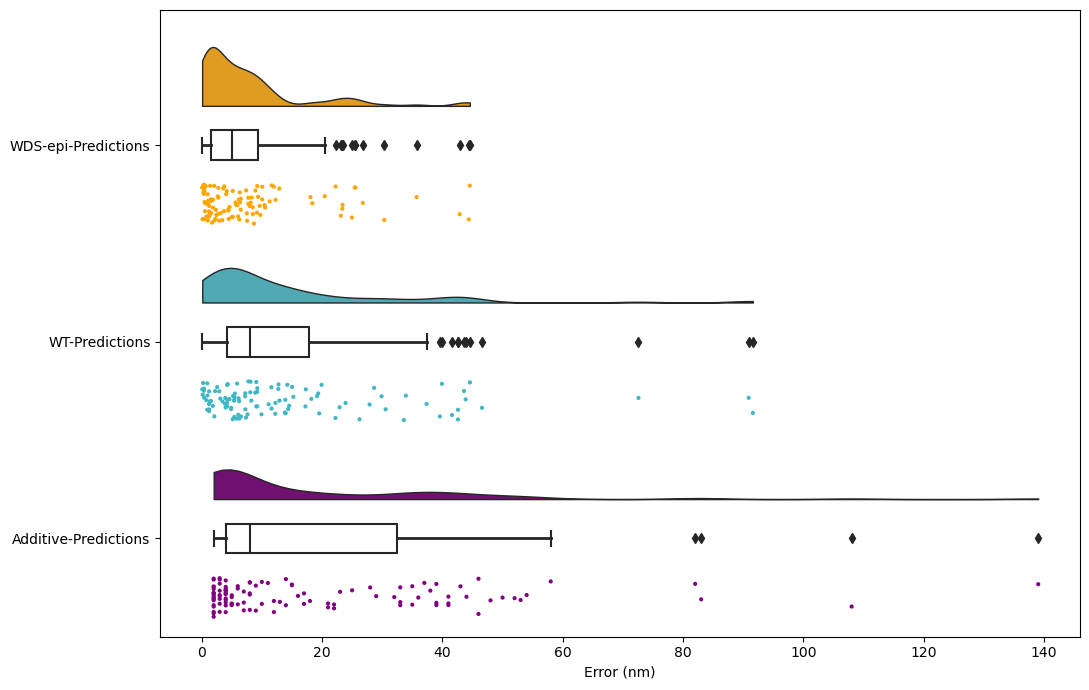

<Figure size 640x480 with 0 Axes>

In [59]:
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


plt.figure(figsize = [11.0, 7.00])
#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']

# Plotting
ax = pt.RainCloud(data=[abs(epi_test['Difference']), abs(wt_test['Difference']), abs(epi_test['Adtv_Err'])], palette=palette, orient='h',
                  bw=.2, width_viol=.6, pointplot=False, dodge=False, move = .3)

# Customize axis labels
plt.yticks([0, 1, 2], ["WDS-epi-Predictions", "WT-Predictions", "Additive-Predictions"])
#plt.xlabel('Predictor')
plt.xlabel('Error (nm)')

plt.tight_layout()
#save file
fileout = 'epi_iter_test_err_rain_plt.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_err_rain_plt.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_20880\1452647484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val = max([d[idx] for d in data]) # Find the maximum value in each plot


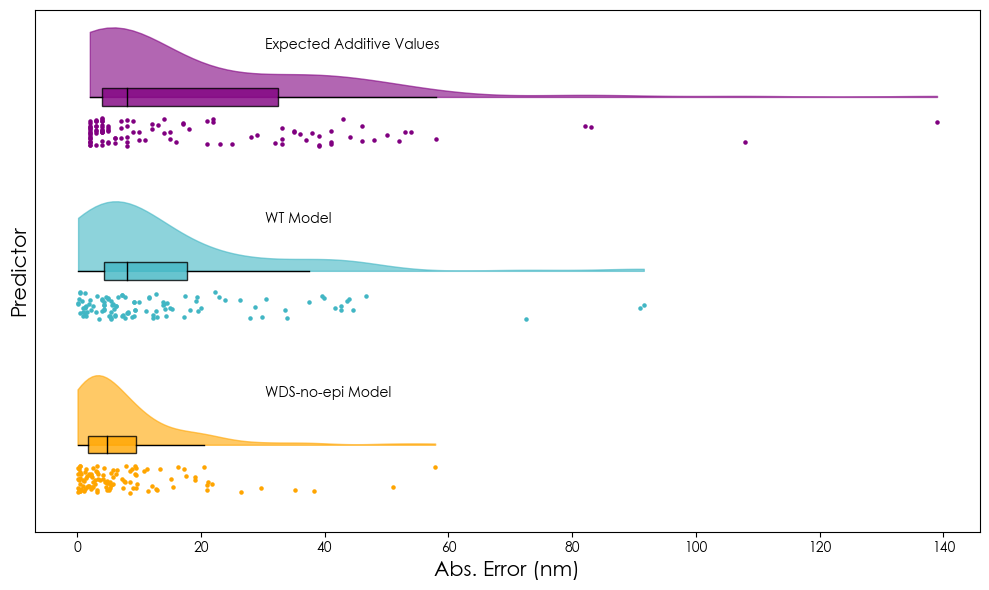

<Figure size 640x480 with 0 Axes>

In [5]:
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(10, 6))

#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']
data=[abs(epi_test['Difference']), abs(wt_test['Difference']), abs(epi_test['Adtv_Err'])]
model_names = ["WDS-no-epi Model", "WT Model", "Expected Additive Values"]


# Boxplot data
bp = ax.boxplot(data, patch_artist = True, vert = False, showcaps= False, showfliers= False, widths=0.1)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
for median in bp['medians']:
    median.set_color('black')


# Violinplot data
vp = ax.violinplot(dataset = data,
                     showmeans=False, showextrema=False, showmedians=False, vert = False, widths= 0.8)
for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
    # Change to the desired color
    b.set_color(palette[idx])
    b.set_alpha(0.6)

# Scatterplot data
for idx, features in enumerate(data):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + .8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.08, high=.08, size=len(idxs))
    y = out
    plt.scatter(features, y, s=5, c=palette[idx])

# Annotate with model names to the right of the plot
top_max = 0
for idx, model_name in enumerate(model_names):
    max_val = max([d[idx] for d in data]) # Find the maximum value in each plot
    if max_val > top_max:
        top_max = max_val
for idx, model_name in enumerate(model_names):
    ax.text(max_val*7, idx + 1.3, model_name, va='center')

# Customize axis labels
plt.rcParams['font.family'] = 'Century Gothic'
#plt.yticks([1, 2, 3], ["WDS-epi-Predictions", "WT-Predictions", "Additive-Predictions"])
plt.yticks([])
plt.ylabel('Predictor', fontsize = 15)
plt.xlabel('Abs. Error (nm)', fontsize = 15)


plt.tight_layout()
#save file
fileout = 'epi_iter_test_err_rain_plt_alt.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_err_rain_plt_alt.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_20880\663744681.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val = max([d[idx] for d in data]) # Find the maximum value in each plot


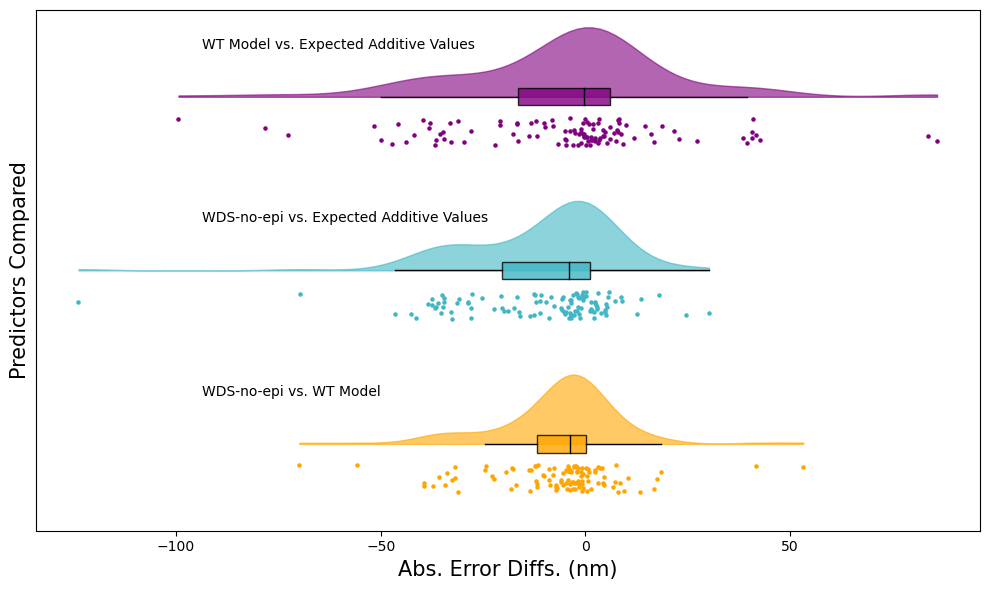

<Figure size 640x480 with 0 Axes>

In [4]:
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(10, 6))

#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']
data=[(abs(epi_test['Difference'])-abs(wt_test['Difference'])), (abs(epi_test['Difference'])-abs(epi_test['Adtv_Err'])), (abs(wt_test['Difference'])-abs(epi_test['Adtv_Err']))]
model_names = ["WDS-no-epi vs. WT Model", "WDS-no-epi vs. Expected Additive Values", "WT Model vs. Expected Additive Values"]


# Boxplot data
bp = ax.boxplot(data, patch_artist = True, vert = False, showcaps= False, showfliers= False, widths=0.1)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
for median in bp['medians']:
    median.set_color('black')


# Violinplot data
vp = ax.violinplot(dataset = data,
                     showmeans=False, showextrema=False, showmedians=False, vert = False, widths= 0.8)
for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
    # Change to the desired color
    b.set_color(palette[idx])
    b.set_alpha(0.6)

# Scatterplot data
for idx, features in enumerate(data):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + .8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.08, high=.08, size=len(idxs))
    y = out
    plt.scatter(features, y, s=5, c=palette[idx])

# Annotate with model names to the right of the plot
top_max = 0
for idx, model_name in enumerate(model_names):
    max_val = max([d[idx] for d in data]) # Find the maximum value in each plot
    if max_val > top_max:
        top_max = max_val
for idx, model_name in enumerate(model_names):
    ax.text(-max_val*70, idx + 1.3, model_name, va='center')

# Customize axis labels
plt.rcParams['font.family'] = 'Century Gothic'
#plt.yticks([1, 2, 3], ["WDS-epi-Predictions", "WT-Predictions", "Additive-Predictions"])
plt.yticks([])
plt.ylabel('Predictors Compared', fontsize = 15)
plt.xlabel('Abs. Error Diffs. (nm)', fontsize = 15)


plt.tight_layout()
#save file
fileout = 'epi_iter_test_comp_err_rain_plt2.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_comp_err_rain_plt2.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_22704\2548150820.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val = max([d[idx] for d in data]) # Find the maximum value in each plot


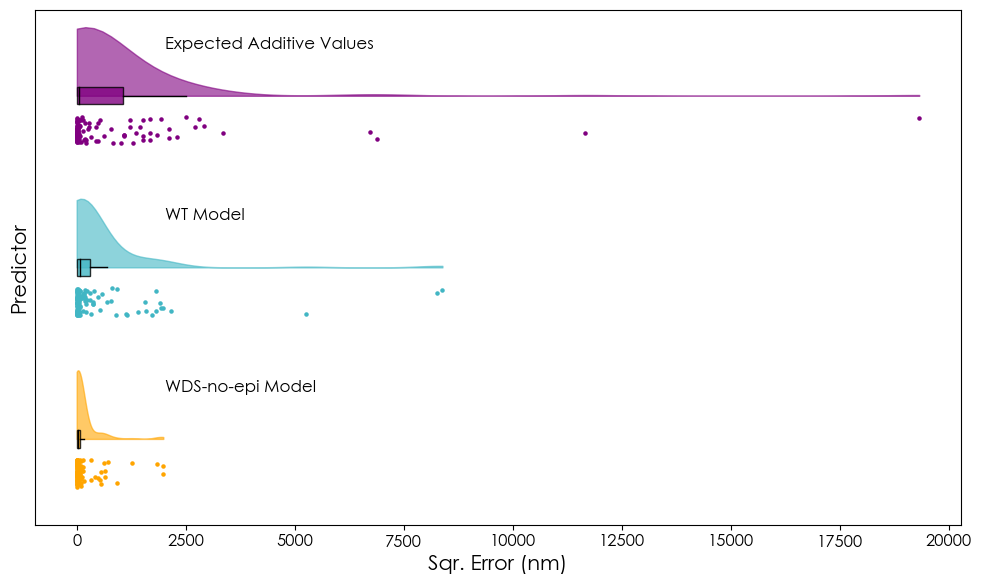

<Figure size 640x480 with 0 Axes>

In [65]:
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 12})

#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']
data=[abs(epi_test['Sqr_Err']), abs(wt_test['Sqr_Err']), abs(epi_test['Adtv_Err']**2)]
model_names = ["WDS-no-epi Model", "WT Model", "Expected Additive Values"]


# Boxplot data
bp = ax.boxplot(data, patch_artist = True, vert = False, showcaps= False, showfliers= False, widths=0.1)
    
# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
for median in bp['medians']:
    median.set_color('black')


# Violinplot data
vp = ax.violinplot(dataset = data,
                     showmeans=False, showextrema=False, showmedians=False, vert = False, widths= 0.8)


for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
    # Change to the desired color
    b.set_color(palette[idx])
    b.set_alpha(0.6)  

# Scatterplot data
for idx, features in enumerate(data):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + .8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.08, high=.08, size=len(idxs))
    y = out
    plt.scatter(features, y, s=5, c=palette[idx])
   
# Customize axis labels
plt.rcParams['font.family'] = 'Century Gothic'

# Annotate with model names to the right of the plot
top_max = 0
for idx, model_name in enumerate(model_names):
    max_val = max([d[idx] for d in data]) # Find the maximum value in each plot
    if max_val > top_max:
        top_max = max_val
for idx, model_name in enumerate(model_names):
    ax.text(max_val*100, idx + 1.3, model_name, va='center')

#legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='orange', markeredgecolor= 'white', markersize=15),
#                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#41b6c4', markeredgecolor= 'white', markersize=15),
#                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='purple', markersize=15)]

# Adjust bbox_to_anchor values to place the legend inside the graph
#plt.legend(handles=legend_handles, labels=model_names, loc='upper right')

#plt.yticks([1, 2, 3],model_names)
plt.yticks([])
plt.ylabel('Predictor', fontsize = 15)
plt.xlabel('Sqr. Error (nm)', fontsize = 15)
# Annotating the center of each distribution

plt.tight_layout()
#save file
fileout = 'epi_iter_test_sqr_err_rain_plt2.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_sqr_err_rain_plt2.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_22704\1968293810.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val = max([d[idx] for d in data]) # Find the maximum value in each plot


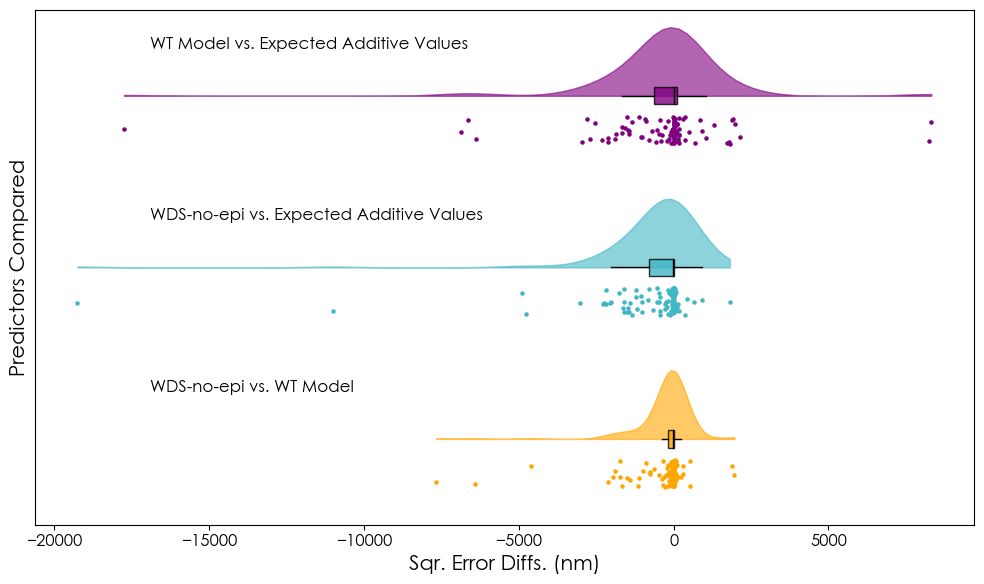

<Figure size 640x480 with 0 Axes>

In [70]:
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 12})

#palette = sns.color_palette("Set2")
palette = ['orange', '#41b6c4', 'purple']
data=[((epi_test['Sqr_Err'])-(wt_test['Sqr_Err'])), ((epi_test['Sqr_Err'])-(epi_test['Adtv_Err']**2)), ((wt_test['Sqr_Err'])-(epi_test['Adtv_Err']**2))]
model_names = ["WDS-no-epi vs. WT Model", "WDS-no-epi vs. Expected Additive Values", "WT Model vs. Expected Additive Values"]


# Boxplot data
bp = ax.boxplot(data, patch_artist = True, vert = False, showcaps= False, showfliers= False, widths=0.1)
    
# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
for median in bp['medians']:
    median.set_color('black')


# Violinplot data
vp = ax.violinplot(dataset = data,
                     showmeans=False, showextrema=False, showmedians=False, vert = False, widths= 0.8)


for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
    # Change to the desired color
    b.set_color(palette[idx])
    b.set_alpha(0.6)  

# Scatterplot data
for idx, features in enumerate(data):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + .8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.08, high=.08, size=len(idxs))
    y = out
    plt.scatter(features, y, s=5, c=palette[idx])
   
# Customize axis labels
plt.rcParams['font.family'] = 'Century Gothic'

# Annotate with model names to the right of the plot
top_max = 0
for idx, model_name in enumerate(model_names):
    max_val = max([d[idx] for d in data]) # Find the maximum value in each plot
    if max_val > top_max:
        top_max = max_val
for idx, model_name in enumerate(model_names):
    ax.text(-max_val*1500, idx + 1.3, model_name, va='center')

#legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='orange', markeredgecolor= 'white', markersize=15),
#                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#41b6c4', markeredgecolor= 'white', markersize=15),
#                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='purple', markersize=15)]

# Adjust bbox_to_anchor values to place the legend inside the graph
#plt.legend(handles=legend_handles, labels=model_names, loc='upper right')

#plt.yticks([1, 2, 3],model_names)
plt.yticks([])
plt.ylabel('Predictors Compared', fontsize = 15)
plt.xlabel('Sqr. Error Diffs. (nm)', fontsize = 15)
# Annotating the center of each distribution

plt.tight_layout()
#save file
fileout = 'comp_epi_iter_test_sqr_err_rain_plt2.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'comp_epi_iter_test_sqr_err_rain_plt2.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

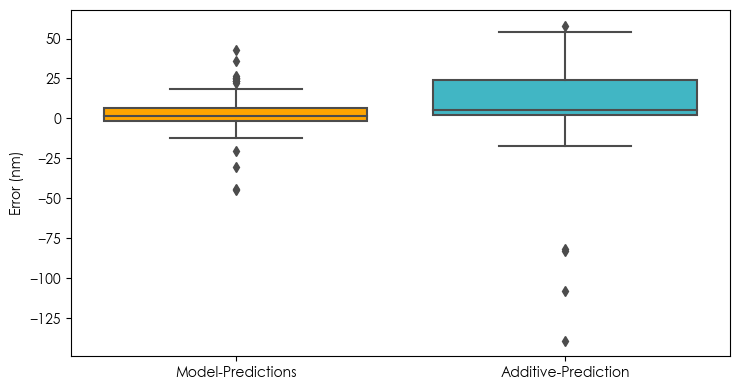

<Figure size 750x400 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['orange','#41b6c4', ]

sns.boxplot(data=[epi_test['Difference'],epi_test['Adtv_Err']], dodge=False, palette=palette, saturation=1)
# Customize axis labels
plt.xticks([0, 1], ["Model-Predictions", "Additive-Prediction"])
#plt.xlabel('Predictor')
plt.ylabel('Error (nm)')

#save file
fileout = 'epi_iter_test_err2_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_err2_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

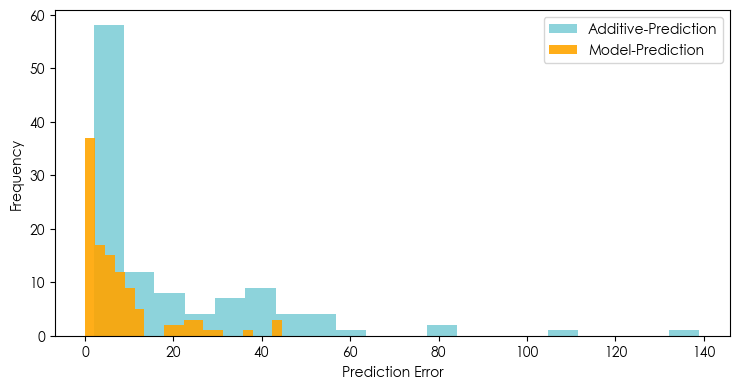

In [42]:
import matplotlib.pyplot as plt
import scipy.stats as st
# ... (your existing code to calculate errors_model1 and errors_model2)

# Histogram
plt.hist(abs(epi_test['Adtv_Err']), bins=20, alpha=0.6, label='Additive-Prediction', color='#41b6c4')
plt.hist(abs(epi_test['Difference']), bins=20, alpha=0.9, label='Model-Prediction', color='orange')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
#plt.title('Histogram of Prediction Errors')
plt.show()

In [43]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], epi_test['Adtv_Err']**2, alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of Exp-Additive Square-Error = {statistics.median(epi_test['Adtv_Err']**2):.1f}nm\nMean of Exp-Additive Square-Error (MSE) = {statistics.mean(epi_test['Adtv_Err']**2):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Adtv_Err']**2)):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
Wilcoxon Test: Statistic = 1122.0 p-value = 2.558061598400896e-09 

Median of WDS-Model Square-Error = 25.3nm
Mean of WDS-Model Square-Error (MSE) = 153.0 // Root Mean Square Error (RMSE) = 12.4nm

Median of Exp-Additive Square-Error = 64.0nm
Mean of Exp-Additive Square-Error (MSE) = 885.9 // Root Mean Square Error (RMSE) = 29.8nm


In [44]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. Exp-Additive]")

statistic, p_value = st.wilcoxon(wt_test['Sqr_Err'], epi_test['Adtv_Err']**2, alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm")
print(f"Median of Exp-Additive Square-Error = {statistics.median(epi_test['Adtv_Err']**2):.1f}nm\nMean of Exp-Additive Square-Error (MSE) = {statistics.mean(epi_test['Adtv_Err']**2):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Adtv_Err']**2)):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. Exp-Additive]
Wilcoxon Test: Statistic = 2643.0 p-value = 0.08563149873275355 

Median of WT-Model Square-Error = 65.3nm
Mean of WT-Model Square-Error (MSE) = 495.2 // Root Mean Square Error (RMSE) = 22.3nm
Median of Exp-Additive Square-Error = 64.0nm
Mean of Exp-Additive Square-Error (MSE) = 885.9 // Root Mean Square Error (RMSE) = 29.8nm


In [45]:
print(f"WDS Epistais Prediction R\u00b2 = {stats.linregress(epi_test['Lambda_Max'],epi_test['Prediction'])[2]**2:.3f}")

print(f"WT Epistais Prediction R\u00b2 = {stats.linregress(wt_test['Lambda_Max'],wt_test['Prediction'])[2]**2:.3f}")

print(f"Expected Additive Prediction R\u00b2 = {stats.linregress(epi_test['Lambda_Max'],epi_test['Adtv_Pred'])[2]**2:.3f}")



WDS Epistais Prediction R² = 0.969
WT Epistais Prediction R² = 0.894
Expected Additive Prediction R² = 0.878


In [46]:
non_atv_pred = len(epi_test['Prediction'])
for pred,adtv in zip(epi_test['Prediction'], epi_test['Adtv_Pred']):
    if abs(pred - adtv) <= 1:
        non_atv_pred-=1
    else:
        pass
    
print(f"{non_atv_pred}/{len(epi_test['Prediction'])} Predictions Were Not Predicted to Be Additive")

105/111 Predictions Were Not Predicted to Be Additive
